# General overview of the independent study course

My main interest revolves around quantum stochastic differential equations. These topics involves stochastic techniques and differential equation solves. I have pursued to implement, from literature, a quantum circuit 'algorithm' to various methods of either stochastic problems (Markovian chain, quantum stocahstic differential eqaution solver) or differential equation solver (basic arithmetic circuit, linear differential equation solver, 4-bit quantum circuit ODE solver). Both topics had overlapping 'procedures/methods' to implement a quantum circuit design. 

In this notebook, I'll focus on methods I learned from trying to implement a differential equation solver. There are two methods that I learned on how to implement an 1st order ODE: manipulation of gate operations ("analog"-like method), and manipulation of an N-(qu)bit statevectors ("digital"-like method). In particular, I'll showcase the "digital"-like method.

The "analog"-like method involes the creation of custom gates, or the manipulation of gates. I like to think of this point of view as trying to change the gate itself and not the actual statevector like the Heisenberg picture. The main approach for this method is to manually create/change a unitary matrix where acted upon a statevector yields the correct values of the differential equation solver. Essentially, we beat the gate and vector into shape where the measurement (probabilities) values are the actual solution to the ODE. This method is, mostly, impractical because it involves a quantum circuit specifically designed to handle one problem at a particular set of parameters, e.g. a special quantum circuit will need to be built for each different parameter. Therefore, the variable and flexibility to use this method is limited since it requires a unique gate component. Much like an analog system (hence why I call it analog-like). However, the actual measurement of these devices in qiskit are quite fast, moreso than the digital-like method. I believe this is because there is less gate operations overall.

The "digital"-like method is similar to classical computation method. They maniupulate N-qubits to act in a way similar to N-classical 0 and 1 bits (hence why I call it digital-like). Except to manipulate a quantum bit we need unitary gate operations and numerous amounts of trials to get an accurate reading.  This can drastically increases computational time, at least in qiskit (there is potentially time-saving-qiskit pratices for quantum algorithms that I have not employed). Although, this method is potentially more time consuming than the "analog"-like method, the maniupulation of bits to solve ODEs is more flexibile and versitale, i.e. this method is not limited to a special gate components. 


The following section is a demonstration/example of what I learned, specifically ODE solver using "digital"-like method. The following notebooks I created that relate to this topic is Cobarrubia_Quantum_ODE_Solver.ipynb, and Cobarrubia_basic_arithmetic_circuits.ipynb. 


# Packages 

In [1]:
import numpy as np
from qiskit import *
import math
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, QuantumRegister
from sympy import *
from math import pi
from qiskit.circuit import Parameter
%matplotlib inline
from scipy.integrate import odeint,solve_ivp
import pandas as pd
from qiskit.circuit.library.standard_gates import HGate
import timeit

In [2]:
# Visualization packages
from qiskit.visualization import plot_state_city, plot_bloch_vector,plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

In [3]:
# Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')
backend_vec = Aer.get_backend('statevector_simulator')
backend_uni = Aer.get_backend('unitary_simulator')

In [4]:
#parameters
N_shots = 4500
N_time = 10000

In [5]:
# Register circuit (total qubits in the network)
q_1 = QuantumRegister(4)
c_1 = ClassicalRegister(4) 
qt = QuantumRegister(4)
ct = ClassicalRegister(4) 
qt2 = QuantumRegister(8)
ct2 = ClassicalRegister(8) 
# Register circuit (total qubits in the network)
q2 = QuantumRegister(16) 
c2 = ClassicalRegister(16)

## Manipulation of an N-(qu)bit system ("Digital"-like method)

Let's consider the following coupled 1st order ODE:

$$ \frac{d}{dt}\begin{pmatrix}u_1(t) \\ u_2(t)\end{pmatrix} = \begin{pmatrix} u_2(t) \\ -u_{1}(t)\end{pmatrix} = \vec{f}(\vec{u}(t),t)$$

where $t \ge 0$ and $\vec{u}(0) = (u_{1}(0), u_{2}(0))^{\top}$.

The solution to this equation, both analytical and numerical, is easy to find. It is superposition of sine and cosine functions depending on their initial value. The analytical answer yields,


$$ \vec{u}(t) = \begin{pmatrix} cos(t) & sin(t) \\ -sin(t) & cos(t) \end{pmatrix} \begin{pmatrix} u_1(0) \\ u_{2}(0)\end{pmatrix}$$

Below is code to find this numerically with classical techniques.

In [6]:
def classical_way(t,z):
    #y is a vector [u1(0),u2(0)]
    x,y = z
    dydt = [y,-x]
    return dydt

In [7]:
y0 = [0,-1]
time = np.linspace(0,7,N_time)
sol = solve_ivp(classical_way, [0,7],y0, method='RK45',dense_output=True, t_eval=time)
sol_u1_ana = y0[0]*np.cos(time) + y0[1]*np.sin(time)
sol_u2_ana = y0[1]*np.cos(time) - y0[0]*np.sin(time)

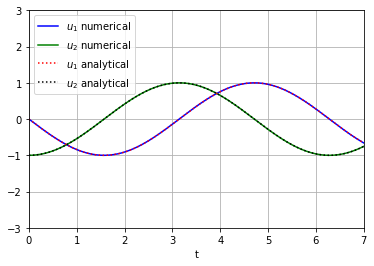

In [8]:
plt.plot(sol.t, sol.y[0, :], '-b', label='$u_1$ numerical')
plt.plot(sol.t, sol.y[1, :], '-g', label='$u_2$ numerical')
plt.plot(time, sol_u1_ana, ':r', label='$u_1$ analytical')
plt.plot(time, sol_u2_ana, ':k', label='$u_2$ analytical')
#plt.plot(time, z.T)
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(-3,3)
plt.xlim(0,7)
plt.grid()
plt.show()

With the classical code we have used Runge-Kutta to solve this.

As we move to talk about quantum circuit method, we will devise a Euler scheme to solve the ODE. But first we need to know the limitation of the following technqiue. The quantum circuit algorithm is based on arXiv:2012.09469v1 "Quantum Algorithms for Solving Ordinary Differential Equations" by Zanger $\textit{et. al.}$ design.

The basic arithmetic circuits used in this notebook can only add/subtract two numbers with the same amount of bits, and we will only divide by two (technically multiplying by 0.5 since we will assume the time step $\Delta t = 0.5$). One reason why we will do this is because division by 2 is easy in two complement representation (shifting the bits to the left rounds to negative infinity then divides by 2). 

Let's consider a number $a$ in Two's complement with N amount of qubits, and q amount of qubits are allotted to the number of decimal points (q = 1 for our case), such that 

$$  a = -2^{N-2}a_{N-1}  + 2^{N-3}a_{N-2} + ... + 2^{0}a_{1} + 2^{-1}a_{0}.$$

We will consider the statevector of this number as $|a\rangle = |a_{N-1}a_{N-2}...a_{1}a_{0}\rangle$.


### Addition/Subtraction and Division by 2

The basic arithmetic circuits for adding or subtracting can be found using the quantum Fourier transform (see Cobarrubia_basic_arithmetic.ipynb). The basic idea is that there is an operator $\hat{\mathcal{X}}$ (canonical 'position' operator) which acted on a continuous variable state yields an eigenstate that is the number itself, i.e. $\hat{\mathcal{X}}|a\rangle = a|a\rangle$. In a similar manner, we can define the momentum operator $\hat{\mathcal{P}} = F^{\dagger}\hat{\mathcal{X}}F$ where $F$ is the Fourier transform. 

Given the following ($\hbar = 1$ and the Hamiltonian is $\hat{\mathcal{P}}$),

$$ \frac{d}{dt}\hat{\mathcal{X}} = -i[\hat{\mathcal{X}},\hat{\mathcal{P}}^2]$$
with 
$$ [\hat{\mathcal{X}},\hat{\mathcal{P}}] = i. $$

The general solution is $\hat{\mathcal{X}} \sim  C(0)\exp\{i\hat{\mathcal{P}}\}$. 

Let $\hat{\mathcal{X}}_{B}$ be another 'position' operator such that $\hat{\mathcal{X}}_{B}|b\rangle = b|b\rangle$. Therefore, $\exp\{i(\hat{\mathcal{X}}_{A} \otimes \hat{\mathcal{P}}_{B})\}|ab\rangle = |a(a+b)\rangle$. We can always simplify $\exp\{i(\hat{\mathcal{X}}_{A} \otimes \hat{\mathcal{P}}_{B})\}$ as $F^{\dagger}_{B}\exp\{i(\hat{\mathcal{X}}_{A} \otimes \hat{\mathcal{X}}_{B})\}F_{B}$.

The outcome where the highest probability is much greater than the any other outcome is the true solution. 


This idea allows us to add and subtract two numbers. However, this method only works for two numbers with the same number of qubits. The consequence is that we get overflowing issues (possibility $(a+b)$ needs more bits to accurate represent). Another, minor issue, is that the algorithm devised below replaces the bottom qubit (we refer to T. G. Draper arXiv:quant-ph/0008033 for further clarification). In addition, circuits with increasing number of gate operations needs even more trials to get an accurate reading. For each time step of the ODE solver, we increase the number of gate operations which increases the total number of trials needed for an accurate prediction.


The last topic that we need to talk about is division by 2. For a two's complement number, a bit shifted left is equivalent as rounding towards negative infinity and then dividing by two. We have specified this division in the divide_by_two() function for a 4-bit number. 

As one can guess, on-top of the large time step and potential overflow problems, we will have inert rounding errors due to rounding. 


### quantum Fourier transform

In [9]:
#(taken from qiskit documentation)
def qft_rotations(circuit, n, n1):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    if n1 >= n:
        return circuit
    #print(n1)
    circuit.h(n1)
    for qubit in reversed(range(n)):
        #print(qubit)
        if qubit > n1:
            circuit.cp((2*np.pi)/2**(qubit-n1+2), qubit, n1)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    #print(n1)
    n1 += 1
    qft_rotations(circuit, n, n1)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n, 0)
    #swap_registers(circuit, n)
    return circuit
def qft_inv(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    #swap_registers(circuit, n)
    return circuit.decompose()


### Addition and Subtraction algorithm 

In [10]:
def add_fourier_way(circuit, na, nb,n,start,stop):
    # na: number of qubits for the ath number
    # nb: number of qunits for the bth number
    # n: total number of qubits 
    # start: the qubit to start the addition
    # stop: total number of qubits for the ath number
    if nb == 0:
        return circuit
    nb -= 1
    na -= 1
    for qubit in range(start, stop):
        #print('hi',qubit,st)
        circuit.cp((2*np.pi)/2**(qubit-start+1), qubit  , n - (nb+1))
    #print(nb)
    #circuit.barrier()
    start += 1
    add_fourier_way(circuit, na, nb,n,start,stop)
    
    
def sub_fourier_way(circuit, na, nb,n,start,stop):
    # na: number of qubits for the ath number
    # nb: number of qunits for the bth number
    # n: total number of qubits 
    # start: the qubit to start the addition
    # stop: total number of qubits for the ath number
    if nb == 0:
        return circuit
    nb -= 1
    na -= 1
    for qubit in range(start, stop):
        #print('hi',qubit,st)
        circuit.cp((-2*np.pi)/2**(qubit-start+1), qubit  , n - (nb+1))
    #print(nb)
    
    start += 1
    circuit.barrier()
    sub_fourier_way(circuit, na, nb,n,start,stop)

def add_qc(circuit, na, nb,n,start,stop):
    add_fourier_way(circuit, na, nb,n,start,stop)
    return circuit
def sub_qc(circuit, na, nb,n,start,stop):
    sub_fourier_way(circuit, na, nb,n,start,stop)
    return circuit

### Division by 2 for a 4-bit number

In [11]:
def divide_4bit_two(circuit,qb_vec):
    dum_cir = QuantumCircuit(4,name='number/2')
    dum_cir.initialize([1,0],3)
    dum_cir.cx(0,3)
    dum_cir.swap(2,3)
    dum_cir.swap(1,2)
    circuit.append(dum_cir,qb_vec)
    return circuit

### ODE SOLVER

Here we imploy Euler's scheme such that 

$$ \vec{u}_{n+1} = \vec{u}_{n} + \Delta t \vec{f}(\vec{u}_{n}), $$

where n is the time slice indice, $\Delta t$ is the time step, $f_{1} = u_{1,n}$, and $f_2 = u_{2,n}$. 

Let's compute the ODE given that $\vec{u}(0) = (0,-1)^{\top}$.

In [12]:
def time_4bit_slice(circuit,n):
    
    
    if n != 16:
        return Print('Incorrect total qubit number')
    
    #f1(u) = u_2
    circtf = qft(QuantumCircuit(4,name='qft'),4)
    circuit.append(circtf,[8,9,10,11])


    circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
    circuit.append(circadd, [4,5,6,7,8,9,10,11])


    circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
    circuit.append(circtfinv,[8,9,10,11])
    circuit.barrier()



    #f2(u) = u_1

    circtf2 = qft(QuantumCircuit(4,name='qft'),4)
    circuit.append(circtf2,[12,13,14,15])

    circadd2 = sub_qc(QuantumCircuit(8,name='sub'), 4, 4, 8,0,4)
    circuit.append(circadd2, [0,1,2,3,12,13,14,15])

    circtfinv2 = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
    circuit.append(circtfinv2,[12,13,14,15])

    circuit.barrier()

    divide_4bit_two(circuit,[8,9,10,11])
    divide_4bit_two(circuit,[12,13,14,15])
    circuit.barrier()

    ## Add f1(u) to u_1

    circtf = qft(QuantumCircuit(4,name='qft'),4)
    circuit.append(circtf,[0,1,2,3])

    circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
    circuit.append(circadd, [8,9,10,11,0,1,2,3])


    circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
    circuit.append(circtfinv,[0,1,2,3])
    circuit.barrier()


    ## Add f2(u) to u_2



    circtf = qft(QuantumCircuit(4,name='qft'),4)
    circuit.append(circtf,[4,5,6,7])


    circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
    circuit.append(circadd, [12,13,14,15,4,5,6,7])


    circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
    circuit.append(circtfinv,[4,5,6,7])
    circuit.barrier()



    ##### Compute the Second Slice


   
    return circuit

In [13]:
## I had help from the internet. Here is the overstack form where I got this function https://stackoverflow.com/questions/1604464/twos-complement-in-python
def two2dec(s):
      if s[0] == '1':
        return -1 * (int(''.join('1' if x == '0' else '0' for x in s), 2) + 1)
      else:
        return int(s, 2)

### The first time slice of the ODE

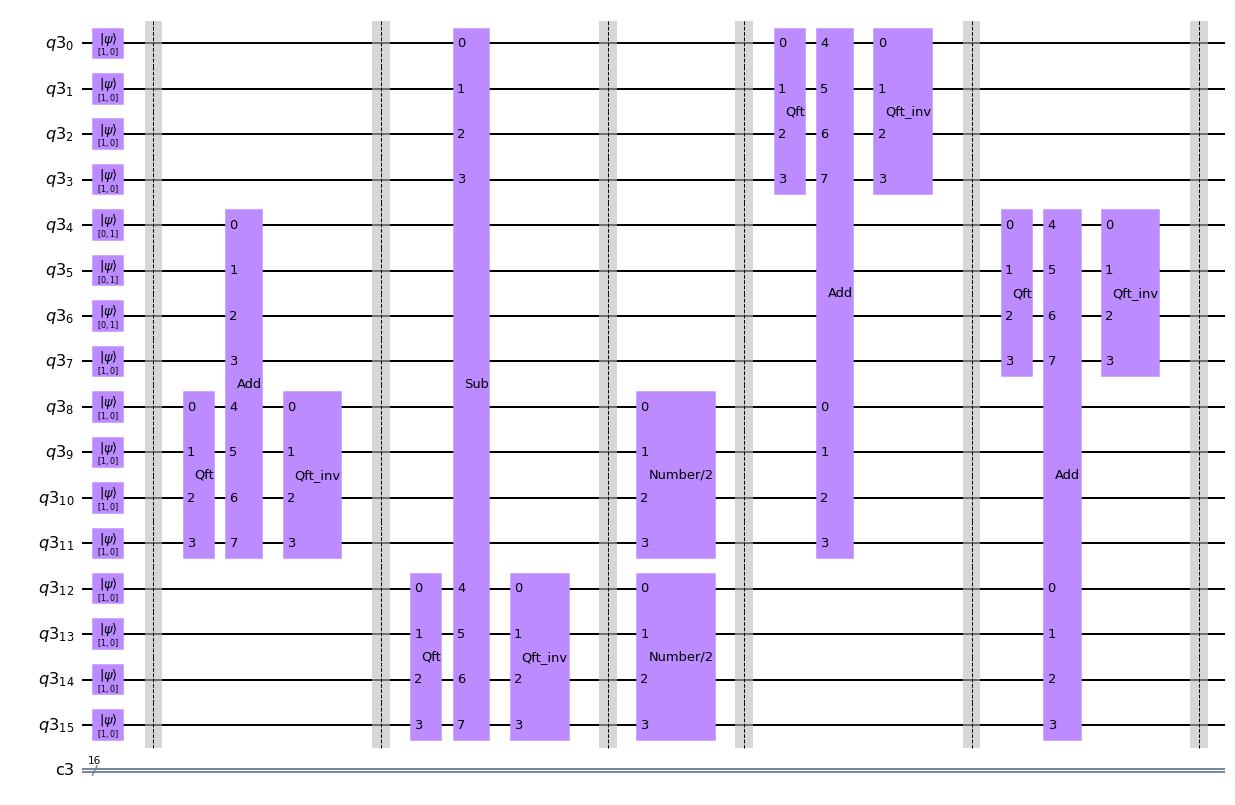

In [14]:
# The first slice of Euler's method (cicuit graphic)
qct = QuantumCircuit(q2,c2)
# u_1(0)= 0 =   -2^3a_3 + 2^2a_2 + 2^1a_1 + a_0
qct.initialize([1,0],0) # a_3 = 0
qct.initialize([1,0],1) # a_2 = 0
qct.initialize([1,0],2) # a_1 = 0
qct.initialize([1,0],3) # a_0 = 0
#u_2(0) = -1 = -2^3b_3 + 2^2b_2 + 2^1b_1 + b_0
qct.initialize([0,1],4) # b_3 = 1
qct.initialize([0,1],5) # b_2 = 1
qct.initialize([0,1],6) # b_1 = 1
qct.initialize([1,0],7) # b_0 = 0
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)

qct.barrier()


time_4bit_slice(qct,16)

qct.draw('mpl')

In [31]:
# The first slice of Euler's method
qct = QuantumCircuit(q2,c2)
# u_1(0)= 0 =   -2^3a_3 + 2^2a_2 + 2^1a_1 + a_0
qct.initialize([1,0],0) # a_3 = 0
qct.initialize([1,0],1) # a_2 = 0
qct.initialize([1,0],2) # a_1 = 0
qct.initialize([1,0],3) # a_0 = 0
#u_2(0) = -1 = -2^3b_3 + 2^2b_2 + 2^1b_1 + b_0
qct.initialize([0,1],4) # b_3 = 1
qct.initialize([0,1],5) # b_2 = 1
qct.initialize([0,1],6) # b_1 = 1
qct.initialize([1,0],7) # b_0 = 0
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)


time_4bit_slice(qct,16)


qct.measure(range(16),range(16))

resultsn1 = execute(qct,backend = backend_sim, shots = N_shots).result()

countsn1 = resultsn1.get_counts()

string_solution = max(countsn1, key=countsn1.get)
solu2_n1 = two2dec(string_solution[11]+string_solution[10]+string_solution[9]+ string_solution[8])/2
solu1_n1 = two2dec(string_solution[15]+string_solution[14]+string_solution[13]+string_solution[12])/2

In [34]:
# The second slice of Euler's method
qct = QuantumCircuit(q2,c2)
# u_1(0)= 0 =   -2^3a_3 + 2^2a_2 + 2^1a_1 + a_0
qct.initialize([1,0],0) # a_3 = 0
qct.initialize([1,0],1) # a_2 = 0
qct.initialize([1,0],2) # a_1 = 0
qct.initialize([1,0],3) # a_0 = 0
#u_2(0) = -1 = -2^3b_3 + 2^2b_2 + 2^1b_1 + b_0
qct.initialize([0,1],4) # b_3 = 1
qct.initialize([0,1],5) # b_2 = 1
qct.initialize([0,1],6) # b_1 = 1
qct.initialize([1,0],7) # b_0 = 0
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)



time_4bit_slice(qct,16)
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)

time_4bit_slice(qct,16)


qct.measure(range(8),range(8))

resultsn2 = execute(qct,backend = backend_sim, shots = N_shots).result()

countsn2 = resultsn2.get_counts()

string_solution = max(countsn2, key=countsn2.get)
solu2_n2 = two2dec(string_solution[11]+string_solution[10]+string_solution[9]+ string_solution[8])/2
solu1_n2 = two2dec(string_solution[15]+string_solution[14]+string_solution[13]+string_solution[12])/2

In [35]:
# The third slice of Euler's method
qct = QuantumCircuit(q2,c2)
# u_1(0)= 0 =   -2^3a_3 + 2^2a_2 + 2^1a_1 + a_0
qct.initialize([1,0],0) # a_3 = 0
qct.initialize([1,0],1) # a_2 = 0
qct.initialize([1,0],2) # a_1 = 0
qct.initialize([1,0],3) # a_0 = 0
#u_2(0) = -1 = -2^3b_3 + 2^2b_2 + 2^1b_1 + b_0
qct.initialize([0,1],4) # b_3 = 1
qct.initialize([0,1],5) # b_2 = 1
qct.initialize([0,1],6) # b_1 = 1
qct.initialize([1,0],7) # b_0 = 0
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)

qct.barrier()


time_4bit_slice(qct,16)
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)

time_4bit_slice(qct,16)
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)

time_4bit_slice(qct,16)

qct.measure(range(8),range(8))

resultsn3 = execute(qct,backend = backend_sim, shots = N_shots).result()

countsn3 = resultsn3.get_counts()

string_solution = max(countsn3, key=countsn3.get)
solu2_n3 = two2dec(string_solution[11]+string_solution[10]+string_solution[9]+ string_solution[8])/2
solu1_n3 = two2dec(string_solution[15]+string_solution[14]+string_solution[13]+string_solution[12])/2

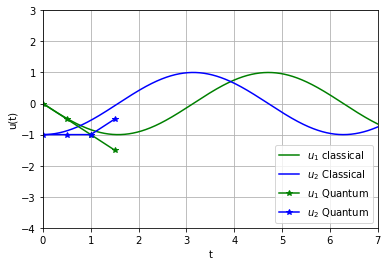

In [38]:
plt.plot(sol.t, sol.y[0, :], '-g', label='$u_1$ classical')
plt.plot(sol.t, sol.y[1, :], '-b', label='$u_2$ Classical')
plt.plot([0,0.5,1.0,1.5], [ 0.0,solu1_n1,solu1_n2,solu1_n3], '*-g', label='$u_1$ Quantum')
plt.plot([0,0.5,1.0,1.5], [-1.0,solu2_n1,solu2_n2,solu2_n3], '*-b', label='$u_2$ Quantum')
#plt.plot(time, z.T)
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.ylim(-4,3)
plt.xlim(0,7)
plt.grid()
plt.show()

Calculating higher time slices requires more computational time. This is because we need more trials as the nth time slice approaches the final mth time slice. Going from the 2nd time slice to 3rd time slice needed approximately 1000 more trials to get an 'accurate' data point (as accurate as we can achieve given overflow and rounding error doesn't dominate the dynamics). The 4th time slice inaccuracy arises. (Below is the result of 14 time slices with N_shots = 25000. This took 13+ hours to complete).

### Comparison ebtween classical versus quantum solution from t = 0 to t = 7

In [30]:
from IPython.display import IFrame
IFrame("ODE_Solver.pdf", width=600, height=300)

### Future Work (Improvements to Zanger's paper)

Zanger $\textit{et. al.}$ provides an excellent example to demonstrate basic/"primitive", yet interesting application of quantum circuits. I believe this work is more or less a stepping stone to better quantum algorithms for ODE, but also differential equation solvers in general. Maybe application to other related computation algorithms too.

However, there are certain parts of the quantum Euler's scheme algorithm that can be improved further (here is a paper that has some solutions to the following problems arXiv:2005.00443 [cs.IT] by Engin Şahin):

1.) The algorithm presented here (Zanger's paper) is exclusively for two numbers with the same bits. As explained before, this creates overflow issues which can have a drastic impact in viable computation. An addition/subtraction circuit for an N-bit number plus an M-bit number can be extended.

2.) Multiplication and division can be added and generalized to a multi-bit system. However, this will increase the number of ancilla qubits to do proper division/multiplication, increase the error, and computational time. 


## What I wished to know before taking this course

I believe learning two main topics: continuous variable quantum computing and classical computational methods (two's complement). 

For the former, from my brief introduction on this manner there can be potential advantage in using this form. As we saw here, we can utilize the quantum Fourier transform to essentially do all elementary arithmetic calculations with less amount of qubits involved. I believe this topic would have greatly further my understanding of quantum ODE solvers. Here is the paper that Zanger referenced for more info on continuous variable quantum computing: arXiv:quant-ph/0410100 "Quantum information with continuous variables" by Samuel L. Braunstein and Peter van Loock.

The last method is more of a a lacking of understanding on how to manipulate classical bits. In particular, I had understanding on how to implement a two's complement, and how to represent/assign bits of a decimal with fractional values. Manipulation of classical bits, I believe would have helped me understand the digital application to quantum circuits better. 